### 3. Data Preparation
The process involves;
- Importing libraries
- Loading dataset and checking what it contains

In [1]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import os
import re
import sys
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
import xgboost as xgb
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing libraries
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# load the dataset and preview first five rows
data = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
# getting information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
# getting the shape of the data
data.shape

(9093, 3)

In [6]:
# Calculate sentiment counts
sentiment_counts = data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
print(sentiment_counts)


is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64


From the value count it's evident that the majority of people who tweeted either do not express any specific emotion towards a brand or product, while a relatively small number of tweets fall into categories where the sentiment (positive or negative) is not clearly discernible

In [7]:
# examine text data
data['tweet_text'].head()

0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
Name: tweet_text, dtype: object

### 4. Data Cleaning

- Dropping unwanted columns
- Handling missing values.
- Renaming columns and sentiment
- Clean text data 
- Text Vectorization

Dropping unwanted columns and 'i cant tell' category 

In [8]:
# dropping emotion_in_tweet_is_directed_at column since we wont be using it modelling
columns_to_drop = ['emotion_in_tweet_is_directed_at']
data = data.drop(columns=columns_to_drop)

In [9]:
# checking if the column has been dropped 
data.head()
# 'the emotion in tweet is directed at' column has been dropped.

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [10]:
# dropping 'i cant tell' and No emotion toward brand or product' category since we will only be using the two sentiments.
data = data[(data['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell")]

In [11]:
# checking to see if 'i cant tell' category has been dropped and 'No emotion toward brand or product' has been replaced
data.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
Name: count, dtype: int64

We have performed data preprocessing by removing the 'emotion_in_tweet_is_directed_at' column, leaving us with two columns for further analysis. Additionally, we have excluded the 'I can't tell' category from the 'emotion' column, resulting in our dataset containing only the 'Positive,' 'Negative,' and 'No emotion toward brand or product' sentiments.

Handling mising values

In [12]:
# checking if our dataset has missing values
data.isna().sum()

tweet_text                                            1
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [13]:
# dropping the row with missing values
# since we cannot impute text
data = data.dropna(subset=['tweet_text'])


In [14]:
# checking if the row with missing values has been dropped
data.isna().sum()

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

Renaming column and 'No emotion toward a brand or product' category

In [15]:
#renaming'is_there_an_emotion_directed_at_a_brand_or_product'column to emotion to make it easy to work with
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}, inplace=True)

In [16]:
# previewing the first five rows to check if the column has been renamed.
data.head()

,tweet_text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [17]:
# renaming 'No emotion toward a brand a brand or product' as neutral for easy analysis
data['emotion'] = data['emotion'].replace({'No emotion toward brand or product': 'Neutral'})


In [18]:
# checking to see if the row has been renamed
data.emotion.value_counts()

emotion
Neutral             5388
Positive emotion    2978
Negative emotion     570
Name: count, dtype: int64

We have simplified our analysis by renaming the 'is_there_an_emotion_directed_at_a_brand_or_product' column to 'emotion' and relabeling 'No emotion toward brand or product' as 'neutral' for clarity and ease of interpretation.

Cleaning text data

In [19]:
# Function to clean text
def clean_text(text):
    # Ensure text is a string
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove hashtags (including the # symbol)
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and punctuation (except spaces)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    return text
   
     #Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(filtered_tokens)

# Function to apply lemmatization
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

# Apply text cleaning to the "tweet_text" column
data['cleaned_tweet'] = data['tweet_text'].apply(clean_text)

# Tokenize the "tweet_text" column
data['tokenized_tweet'] = data['cleaned_tweet'].apply(lambda x: word_tokenize(x))

# Apply lemmatization to the tokenized text
data['lemmatized_tweet'] = data['tokenized_tweet'].apply(lemmatize_text)

# Display the DataFrame with cleaned, tokenized, and lemmatized text
print(data[['tweet_text', 'cleaned_tweet', 'tokenized_tweet', 'lemmatized_tweet']])


                                             tweet_text   
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...  \
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

                                          cleaned_tweet   
0     wesley83 i have a 3g iphone after 3 hrs tweeti...  \
1     jessedee know about fludapp  awesome ipadiphon...   
2     swonderlin can not wait for  2 also they shoul...   
3     sxsw i hope this years festival isnt as crashy...

Tokenization serves to break text into smaller units or tokens, making the text more manageable for analysis. Lemmatization reduces words to their base forms, enhancing standardization and simplification of the text.

Text Vectorization

In [20]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Join the tokenized tweets into a single string with space as a separator
data['lemmatized_tweet'] = data['lemmatized_tweet'].apply(lambda x: ' '.join(x))

# Fit and transform your tokenized text
tfidf_matrix = tfidf_vectorizer.fit_transform(data['lemmatized_tweet'])

# The tfidf_matrix contains the TF-IDF vectors for the tweets

The code prepares and transforms the text data into a numerical format that can be used for sentimental analysis

### 5. Exploratory Data Analysis (EDA) 

Visualize the Distribution of Sentiment Labels

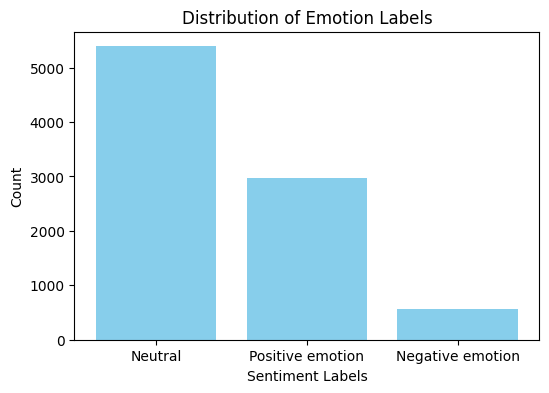

In [21]:
# Assuming you have a DataFrame 'data' with a 'sentiment' column
sentiment_counts = data['emotion'].value_counts()

# Create a bar chart to visualize sentiment distribution
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color="skyblue")
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.title('Distribution of Emotion Labels')
plt.show()


From the visualization it's evident that the majority of people who tweeted either do not express any specific emotion towards a brand or product, while a relatively small number of tweets fall into categories where the sentiment (positive or negative) is not clearly discernible

Generating Word Clouds for Each Sentiment Class

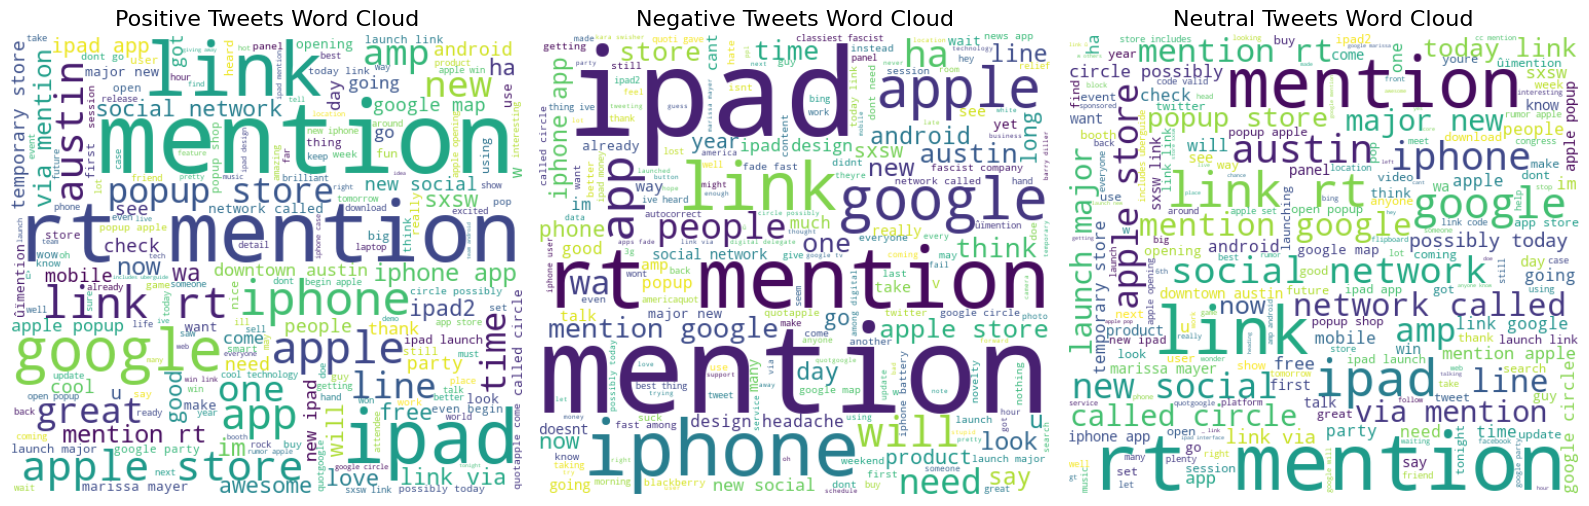

In [22]:
# generating word count using word cloud and getting the visualization
# Separate the dataset into positive, negative, neutral, and can't tell tweets
pos_tweets = data[data['emotion'] == 'Positive emotion']['lemmatized_tweet']
neg_tweets = data[data['emotion'] == 'Negative emotion']['lemmatized_tweet']

# Filter and clean the 'neutral' tweets, handling any non-string values 
neut_tweets = data[data['emotion'] == "Neutral"]['lemmatized_tweet']
#neut_tweets = neut_tweets.dropna().astype(str)  # Convert to string and drop NaN values
# Create a 2x2 grid of subplots for word clouds
plt.figure(figsize=(16, 10))

# Function to create and display a word cloud in a specific subplot
def generate_word_cloud_subplot(text, title, position):
    wordcloud = WordCloud(width=500, height=450, background_color='white', random_state=42).generate(text)
    
    plt.subplot(1,3, position)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')

# Create word clouds for each sentiment category in specific subplots
generate_word_cloud_subplot(' '.join(pos_tweets), 'Positive Tweets Word Cloud', 1)
generate_word_cloud_subplot(' '.join(neg_tweets), 'Negative Tweets Word Cloud', 2)
generate_word_cloud_subplot(' '.join(neut_tweets), 'Neutral Tweets Word Cloud', 3)

plt.tight_layout()  # Ensures that subplots are properly arranged
plt.show()


Visualization of  tweet lengths per category

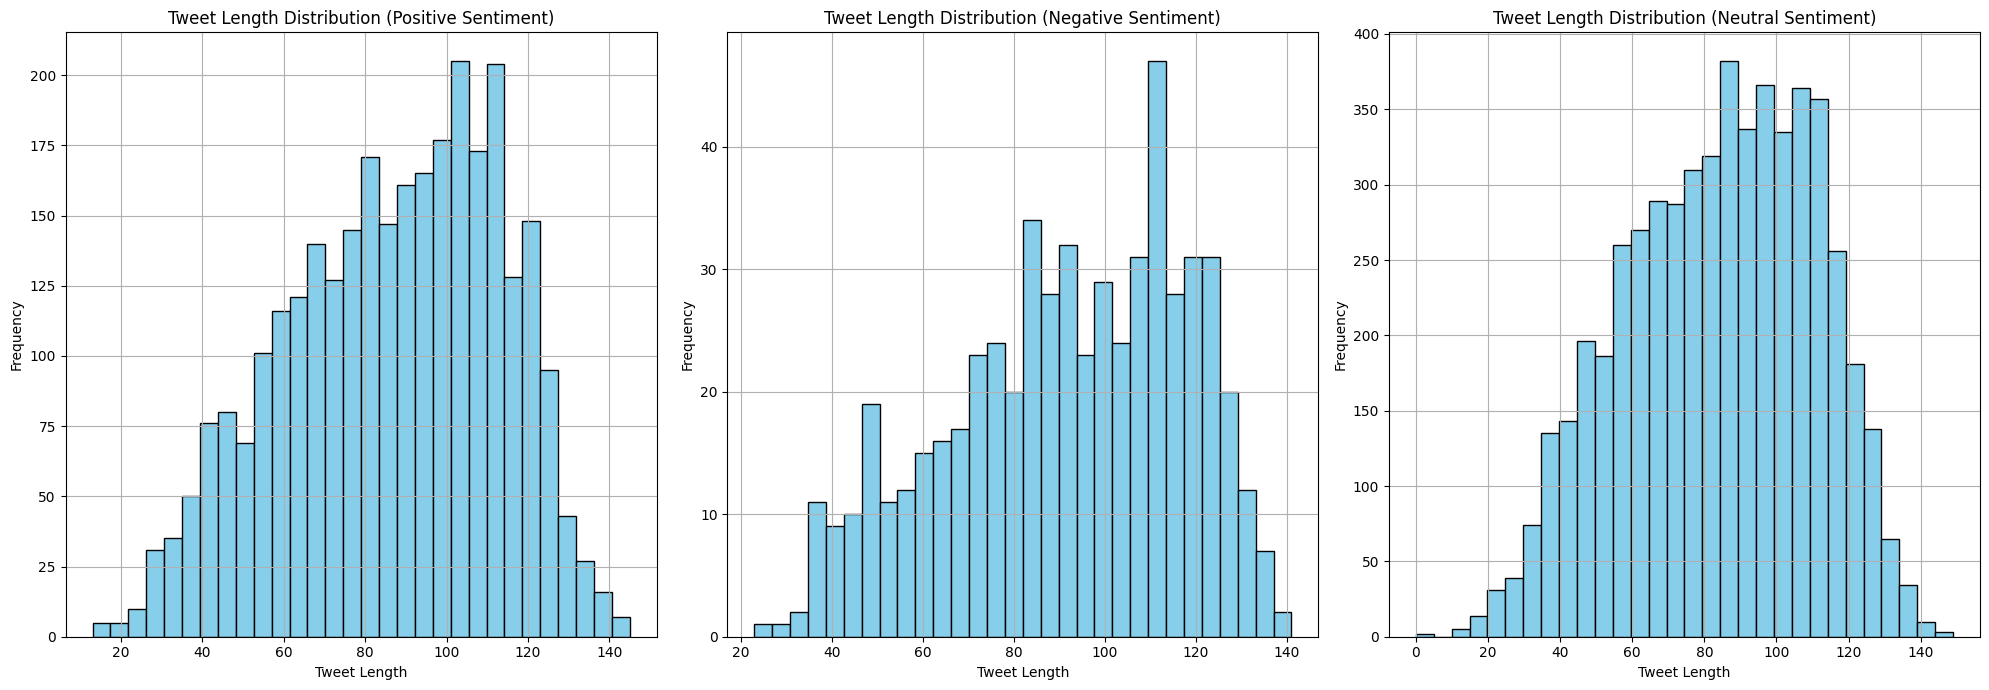

In [23]:
# checking the tweet lengths under each category
# Filter tweets by sentiment category
positive_tweets = data[data['emotion'] == 'Positive emotion']['lemmatized_tweet']
negative_tweets = data[data['emotion'] == 'Negative emotion']['lemmatized_tweet']
neutral_tweets = data[data['emotion'] == 'Neutral']['lemmatized_tweet']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Function to plot tweet length histograms
def plot_tweet_length_histograms(tweets, sentiment_label, ax):
    tweet_lengths = tweets.str.len()
    
    ax.hist(tweet_lengths, bins=30, color='skyblue', edgecolor='black')
    ax.set_xlabel('Tweet Length')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Tweet Length Distribution ({sentiment_label} Sentiment)')
    ax.grid(True)

# Plot histograms for each sentiment category
plot_tweet_length_histograms(positive_tweets, 'Positive', axes[0])
plot_tweet_length_histograms(negative_tweets, 'Negative', axes[1])
plot_tweet_length_histograms(neutral_tweets, 'Neutral', axes[2])

# Adjust subplots for tight layout
plt.subplots_adjust(wspace=0.4)  # Adjust the horizontal space between subplots
plt.tight_layout()  # Ensures a tight layout

# Show the plots
plt.show()


The visualization above reveals that, in terms of tweet length, neutral tweets are the longest, followed by positive tweets and then negative tweets.

### 6. Modelling

####  Binary classification
We begin with binary classification, focusing on negative and positive emotions. We later extend the task to multiclass classification by adding a neutral class. The process involves the following steps:

Data Splitting - We split the filtered data into training and testing sets using the train_test_split function.

Label Encoding - To work with text labels, we encode 'emotion' labels ('Positive emotion' and 'Negative emotion') into numerical values ('Positive' as 1 and 'Negative' as 0) using LabelEncoder.

TF-IDF Vectorization - We utilize TF-IDF vectorization to convert the text data into numerical vectors. The TfidfVectorizer is employed to represent each tweet as a vector of TF-IDF features.

We assess the model's performance through accuracy calculation, a classification report containing precision, recall, and F1-score, and a confusion matrix, providing insights into its performance on individual classes.

The modeling techniques we will use include naive bayes model, fine-tuning the Naive Bayes model and utilizing Support Vector Classification (SVC) to further enhance our sentiment analysis task.

Baseline Model using Naive Bayes

Naive Bayes is selected as the baseline model for its simplicity, computational efficiency, and strong suitability for text classification tasks. Its straightforward nature allows for easy interpretation, making it an ideal starting point for modeling. Additionally, Naive Bayes provides a reasonable baseline performance, offering insights into achievable accuracy without the need for complex algorithms. This will also serve as a benchmark, helping assess whether more advanced models are justified.

In [24]:
# Create a LabelEncoder object to make sure 0 represents negative and 1 positive
label_encoder = LabelEncoder()

#  fit the encoder
custom_encoding = ['Negative', 'Positive']
label_encoder.fit(custom_encoding)

# Check the encoding mapping
encoded_classes = label_encoder.classes_

# Print the mapping
print("Encoded Classes:")
for code, sentiment in enumerate(encoded_classes):
    print(f"Code {code} represents '{sentiment}'")


Encoded Classes:
Code 0 represents 'Negative'
Code 1 represents 'Positive'


In [26]:
# Filter the data to include only 'Positive' and 'Negative' labels
filtered_data = data[(data['emotion'] == 'Positive emotion') | (data['emotion'] == 'Negative emotion')]

# Split the filtered data into features (X) and labels (y)
X = filtered_data['lemmatized_tweet']  # Features
y = filtered_data['emotion']          # Labels (contains 'Positive' and 'Negative' classes)

# Encode labels to numerical values (Positive: 1, Negative: 0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create TF-IDF vectors for text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

# Initialize and train the Naive Bayes classifier
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

# Make predictions on the test set
y_pred = naive_bayes.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Naive Bayes Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Naive Bayes Accuracy: 0.8450704225352113
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       115
           1       0.84      1.00      0.92       595

    accuracy                           0.85       710
   macro avg       0.92      0.52      0.50       710
weighted avg       0.87      0.85      0.78       710

Confusion Matrix:
[[  5 110]
 [  0 595]]


The model performs well getting an accuracy of 84.5%  and correctly identifying 'Positive' tweets with high precision and recall, resulting in a high F1-score for class 1. However, it struggles to identify 'Negative' tweets, as indicated by the very low recall for class 0. The overall accuracy is somewhat inflated due to the class imbalance, where 'Positive' tweets dominate the dataset. Improving recall for class 0 may be a priority if better identification of 'Negative' sentiment is necessary.

Model Iteration 1: Support Vector Machine (SVM)

We transition to SVM to address the limitations observed in the Naive Bayes baseline model. SVMs are known for their versatility in handling imbalanced datasets, which is a challenge in our dataset where 'Positive' tweets dominate. Additionally, SVMs offer the potential to enhance recall for class 0 (negative sentiment) while maintaining high precision and recall for class 1 (positive sentiment), thereby mitigating the initial model's struggles with identifying negative sentiments.

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create Count Vectorizers for text data with custom preprocessor
def custom_preprocessor(text):
    # Convert text to lowercase
    return text.lower()

count_vectorizer = CountVectorizer(max_features=5000, preprocessor=custom_preprocessor)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Initialize and train the SVM classifier with Count Vectors
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train_count, y_train)

# Make predictions on the test set using Count Vectors
y_pred_count = svm_classifier.predict(X_test_count)

# Calculate accuracy with Count Vectors
accuracy_count = accuracy_score(y_test, y_pred_count)
print("SVM Accuracy with Count Vectors:", accuracy_count)

# Display classification report with Count Vectors
print("Classification Report with Count Vectors:")
print(classification_report(y_test, y_pred_count))

# Display confusion matrix with Count Vectors
print("Confusion Matrix with Count Vectors:")
print(confusion_matrix(y_test, y_pred_count))


SVM Accuracy with Count Vectors: 0.8619718309859155
Classification Report with Count Vectors:
              precision    recall  f1-score   support

           0       0.59      0.50      0.54       115
           1       0.91      0.93      0.92       595

    accuracy                           0.86       710
   macro avg       0.75      0.71      0.73       710
weighted avg       0.85      0.86      0.86       710

Confusion Matrix with Count Vectors:
[[ 57  58]
 [ 40 555]]


The SVM classifier achieved an 86.2% accuracy in binary sentiment classification. It excelled in identifying positive sentiment (Class 1) with high precision, recall, and F1-score making it ideal for applications like gauging customer satisfaction. However, it struggled with negative sentiment (Class 0), resulting in lower precision, recall, and F1-score. This limitation raises concerns about missing critical negative feedback. Nevertheless, the weighted average F1-score indicates a reasonably balanced performance for both sentiment classes, aligning with real-world sentiment classification needs.

Model Iteration 2: Random Forest

To further improve the accuracy and address the challenges in identifying class 0 instances (negative sentiment), we consider using a Random Forest classifier as the next model. Random Forests are known for their ability to handle imbalanced datasets and perform well in text classification tasks. They often exhibit robustness in capturing complex patterns and relationships in the data, which can help enhance the classification of negative sentiment tweets. Additionally, Random Forests allow you to experiment with different hyperparameters, such as the number of estimators and maximum depth, to fine-tune the model's performance. This model choice, combined with hyperparameter tuning, can potentially yield improvements in accuracy and overall model performance for both class 0 and class 1 sentiments.

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create TF-IDF vectors for text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize and train the Random Forest classifier
n_estimators = 100  # You can adjust the number of estimators (trees)
random_forest_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
random_forest_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = random_forest_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Random Forest Accuracy: 0.8732394366197183
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.24      0.38       115
           1       0.87      0.99      0.93       595

    accuracy                           0.87       710
   macro avg       0.89      0.62      0.66       710
weighted avg       0.88      0.87      0.84       710

Confusion Matrix:
[[ 28  87]
 [  3 592]]


The random forest model has an improved accuracy of approximately 87.32% on the dataset, indicating its overall effectiveness in classifying sentiment. The precision for identifying negative sentiment tweets is notably high at 90%, signifying that when the model predicts a tweet as negative, it is usually correct. However, the recall for negative sentiment is lower at 24%, implying that the model misses a significant proportion of negative tweets. In contrast, the model performs exceptionally well in identifying positive sentiment tweets, with a precision of 87% and near-perfect recall of 99%. These results are reflected in the F1-scores, where the model achieves an F1-score of 0.38 for negative sentiment and an impressive 0.93 for positive sentiment. The macro-average F1-score is 0.66, considering both sentiments, while the weighted-average F1-score, accounting for class imbalance, is 0.84. In the confusion matrix, the model correctly identifies a substantial number of true positives for positive sentiment but has a significant number of false negatives for negative sentiment.

The Random Forest model stands out as the best binary classification model among those assessed for sentiment analysis in this study. With an accuracy of approximately 87.32%, it outperforms both Naive Bayes and SVM with Count Vectors. The model exhibits a balanced performance, achieving a precision of 90% for negative sentiment and a remarkable 99% recall for positive sentiment. This balance is reflected in its F1-scores, which are 0.38 for negative sentiment and 0.93 for positive sentiment, surpassing the other models. Additionally, in the confusion matrix, the Random Forest model minimizes false negatives for negative sentiment, correctly classifying 28 true negatives and having only 3 false negatives. Overall, its strong accuracy, precision, recall, and F1-scores for both sentiment classes establish it as the most effective binary classification model for sentiment analysis in this context.

#### Multiclass classification

In this section, we will perform multiclass classification, working with three different sentiments. We will follow a similar process as we did for binary classification, with some modifications to accommodate the additional sentiment class

Baseline Model: Naive Bayes with Hyperparameter Tuning Using GridSearchCV

In [31]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the 'emotion' column to encode sentiments
data['emotion_encoded'] = label_encoder.fit_transform(data['emotion'])

# Get the mapping of encoded values to original labels
encoded_classes = label_encoder.classes_

# Print the mapping
print("Encoded Sentiment Values:")
for code, sentiment in enumerate(encoded_classes):
    print(f"Code {code} represents '{sentiment}'")


Encoded Sentiment Values:
Code 0 represents 'Negative emotion'
Code 1 represents 'Neutral'
Code 2 represents 'Positive emotion'


In [32]:
# Split the data into features (X) and labels (y)
X = data['lemmatized_tweet']  # Features
y = data['emotion']          # Labels (contains multiclass labels)

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Vectorize text data  using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Multinomial Naive Bayes classifier
naive_bayes = MultinomialNB()

# Define a grid of hyperparameters to search
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],  # Smoothing parameter
    'fit_prior': [True, False]  # Whether to learn class prior probabilities
}

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform hyperparameter tuning on the training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters from the grid search
best_alpha = grid_search.best_params_['alpha']
best_fit_prior = grid_search.best_params_['fit_prior']

print("Best Alpha:", best_alpha)
print("Best Fit Prior:", best_fit_prior)

# Use the best hyperparameters to train the final model
best_naive_bayes = MultinomialNB(alpha=best_alpha, fit_prior=best_fit_prior)
best_naive_bayes.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = best_naive_bayes.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Tuned Multinomial Naive Bayes Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best Alpha: 0.5
Best Fit Prior: True
Tuned Multinomial Naive Bayes Accuracy: 0.6767337807606264
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.03      0.06       126
           1       0.69      0.90      0.78      1094
           2       0.63      0.39      0.48       568

    accuracy                           0.68      1788
   macro avg       0.66      0.44      0.44      1788
weighted avg       0.67      0.68      0.63      1788

Confusion Matrix:
[[  4  98  24]
 [  2 986 106]
 [  0 348 220]]


The baseline model, a tuned Multinomial Naive Bayes classifier, demonstrates an accuracy of approximately 67.67% in the multiclass sentiment classification task. While it exhibits a relatively high precision (0.69) and recall (0.90) for the 'Positive' sentiment class, achieving an F1-score of 0.78, it struggles with the 'Neutral' and 'Negative' sentiment classes. For 'Neutral,' it obtains a lower precision (0.63) and recall (0.39), resulting in an F1-score of 0.48. The 'Negative' sentiment class poses the most challenge, with a precision of 0.67 and a recall of only 0.03, resulting in a minimal F1-score of 0.06. The confusion matrix reveals the model's difficulty in correctly classifying 'Neutral' and 'Negative' sentiments. Overall, while the baseline model shows promise in identifying 'Positive' sentiment, further improvements are needed to enhance its performance across all sentiment categories, especially 'Neutral' and 'Negative.'

Model iteration 1:Logistic Regression

In [33]:
# Split the data into features (X) and labels (y)
X = data['lemmatized_tweet']  # Features
y = data['emotion']          # Labels (contains multiclass labels)

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Vectorize text data  using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize and train the Logistic Regression classifier
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = logistic_regression.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Logistic Regression Accuracy: 0.6884787472035794
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.09      0.16       126
           1       0.71      0.87      0.78      1094
           2       0.61      0.47      0.53       568

    accuracy                           0.69      1788
   macro avg       0.69      0.48      0.49      1788
weighted avg       0.68      0.69      0.66      1788

Confusion Matrix:
[[ 11  86  29]
 [  3 952 139]
 [  1 299 268]]


In the multiclass classification task using Logistic Regression, the model achieved an accuracy of approximately 68.85%, indicating its ability to correctly classify the sentiment of the provided text data. However, the precision and recall vary across sentiment classes. The model performs relatively well in identifying the 'Positive' sentiment class, with a precision of 0.71 and a recall of 0.87. On the other hand, it struggles with the 'Neutral' sentiment class, achieving a lower precision of 0.61 and a recall of 0.47, and it particularly struggles with the 'Negative' sentiment class, with a precision of 0.73 but a lower recall of 0.09. The F1-scores vary accordingly, with the 'Positive' class having the highest F1-score (0.78), while the 'Neutral' class has a lower F1-score (0.53). The confusion matrix shows the number of true positive, true negative, false positive, and false negative predictions for each sentiment class.

Model iteration 2: Random Forest

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Random Forest classifier
n_estimators = 100  # You can adjust the number of estimators (trees)
random_forest_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Fit the classifier on the training data
random_forest_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = random_forest_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Random Forest Accuracy: 0.6929530201342282
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.19      0.29       126
           1       0.71      0.89      0.79      1094
           2       0.65      0.43      0.52       568

    accuracy                           0.69      1788
   macro avg       0.66      0.50      0.53      1788
weighted avg       0.68      0.69      0.67      1788

Confusion Matrix:
[[ 24  83  19]
 [ 12 973 109]
 [  2 324 242]]


The Random Forest classifier achieved an overall accuracy of approximately 69.3%. It performed well in identifying the neutral class  with a high F1-Score of 0.78, indicating a good balance between precision and recall. However, its performance on the other classeswas lower, particularly in terms of recall.

### 5. Evaluation

In this project, we conducted binary and multiclass sentiment analysis using various machine learning models to determine the best-performing model for the real-world problem of sentiment classification. 

Binary Sentiment Analysis:

- Naive Bayes model served as the baseline and achieved an accuracy of 84.2%. While it performed well in identifying positive sentiments, it struggled with negative sentiments, with a very low recall.
- Support Vector Machine (SVM) improved accuracy to 86.2% and showed better performance in identifying negative sentiments. However, it still had room for improvement in recall for class 0 (negative).
- The Random Forest model outperformed the others, achieving an accuracy of 87.3%. It demonstrated balanced precision and recall for both positive and negative sentiments, making it the best choice for binary sentiment analysis

Multiclass Sentiment Analysis:

- Multinomial Naive Bayes  served as the baseline and achieved an accuracy of 67.7%. While it performed reasonably well for positive sentiments, it struggled with neutral and negative sentiments.
- Logistic Regression model achieved an accuracy of 68.9% but faced challenges in correctly classifying negative sentiments.
- Random Forest model achieved an accuracy of 69.3% and showed balanced performance across sentiments, making it the preferred choice for multiclass sentiment analysis.

Overall, the Random Forest model consistently outperformed other models in both binary and multiclass sentiment analysis tasks. It provides a balanced approach to sentiment classification, which is vital for real-world applications where all sentiment categories are essential. The choice of this model is justified based on its performance and utility for solving the real-world problem of sentiment classification. 